<img src='sharif_logo.png' alt="SUT logo" width=150 height=150 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
 Deep Learning <br>
<font color=2565AE size=5>
Computer Engineering Department - Spring 2025  <br>
<font color=3C99D size=5>
          Homework 3: Practical - GPT2 from Scratch! <br>
<font color=696880 size=4>
            Designer: Shaygan Adim
    
    

# Overview

In this project, you will implement a scaled-down version of OpenAI's GPT-2 architecture from scratch using PyTorch. You'll train this model on the Snappfood comments with sentiment labels. The goal is to create a generative language model that can produce synthetic Persian comments with controllable sentiment (positive or negative).

# Learning Objectives

* Understanding and implementing transformer-based language model architectures  
* Learning how to control text generation using special tokens  
* Visualizing and analyzing training progress  

# Dataset

You'll work with a Persian dataset containing Snappfood comments:  

* The dataset texts are normalized (No need for any normalizations)
* Each comment has a sentiment label (1 for positive, 0 for negative)
* The dataset contains text with variations in length and style

# Tokenizer and model

You should use one of the sota open-source LLM tokenizers. I strongly recommend using Llama 3.3 tokenizer or Gemma-2 tokenizer as they're better than the others in Persian language. (There is no need to implement a tokenizer yourself.)

Your model should have the exact srtructure of GPT-2:  
  
<img src="GPT-2.png" alt="" width="600" height="800">
  
For the model to be able to smoothly be trained, you should use the config below:

* **Embedding Dimension**: 192 (reduced from 768 in original GPT-2)
* **Layers**: 3 transformer blocks (reduced from 12 in original GPT-2)
* **Attention Heads**: 3 (reduced from 12 in original GPT-2)
* **Context Window**: 128 tokens (reduced from 1024 in original GPT-2)

Moreover, unlike the original Transformer paper that used fixed sinusoidal position encodings, GPT-2 (and your implementation) should use learnable position embeddings:
1. You should create an embedding table of size [n_positions, n_embd] where:

    * n_positions is the maximum sequence length (128 in our model)
    * n_embd is the embedding dimension (192 in our model)
2. For each position in the sequence (0 to sequence_length-1), we look up the corresponding embedding vector.

3. These position embeddings are added to the token embeddings before being passed through the transformer blocks.

# Some notes:

* Be aware that you will be questioned about your solution to this assignment in-person. Thus, build a solid understanding through out solving this assignment.
* Using ChatGPT and other LLMs are allowed but you should be able to explain every line of your code completely.
* You need GPU for this assignment. Use can use Colab or Kaggle for free.
* I highly recommend using the exact same structure and instructions that is provided for you in the notebook but minor changes will be tolerated.
* Read the whole notebook once before coding. It will give you a broad vision about what you should do on the whole.
* Instructions provided for you in TODO sections ARE NOT the only things that you should do in those parts. They're just some important bullet points that your code should have.
* The final results (Inference section) should have the minimum quality of the samples already generated in the notebook.

# Importing

In [1]:
from sys import prefix

# Data loading and manipulation
import kagglehub
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sympy.physics.units import temperature

# Tokenization utilities
from transformers import AutoTokenizer
from huggingface_hub import login

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Visualization tool
import matplotlib.pyplot as plt

# Runtime utilities
import time
from tqdm import tqdm

# Typing tool
from typing import Dict, Optional, Any

# Downloading and loading the data

In this section we read and load the data from [here](https://www.kaggle.com/datasets/mohammad1ziyar/cleaned-snappfood-persian-sentiment-analysis).

You can also see some information about the data in the next cell. In the end, we only want the label and cleaned columns.

In [2]:
#  Download the dataset using kagglehub

path = "/kaggle/input/cleaned-snappfood-persian-sentiment-analysis"

print("Path to dataset files:", path)

raw_corpus = pd.read_csv(path + "/cleaned_snappfood.csv")

Path to dataset files: /kaggle/input/cleaned-snappfood-persian-sentiment-analysis


In [3]:
raw_corpus.info()
raw_corpus.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65973 entries, 0 to 65972
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   comment          65973 non-null  object
 1   label            65973 non-null  int64 
 2   comment_length   65973 non-null  int64 
 3   comment_cleaned  65973 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.0+ MB


,comment,label,comment_length,comment_cleaned
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,0,47,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,1,132,قرار بود ساعته برسه ولی نیم ساعت زودتر از موق...
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,0,89,قیمت این مدل اصلا با کیفیتش سازگاری نداره فقط ...
3,عالی بود همه چه درست و به اندازه و کیفیت خوب، ...,1,99,عالی بود همه چه درست و به اندازه و کیفیت خوب ا...
4,شیرینی وانیلی فقط یک مدل بود.,1,29,شیرینی وانیلی فقط یک مدل بود


In [4]:
raw_corpus = raw_corpus[["comment_cleaned", "label"]]

# Downloading and loading the tokenizer (5 Points)

In this section you need to load your tokenizer from hugging face. I recommend [this](https://huggingface.co/meta-llama/Llama-3.3-70B-Instruct) or [this](https://huggingface.co/google/gemma-2-27b-it).
Keep in mind that you might need to login first using your hugging face access token and also sign an agreement thing in model's page to be able to access the model and it's tokenizer.

In [ ]:
#  Set up authentication (if needed) and initialize a tokenizer
#  Use the login() function to authenticate with your Hugging Face token (if needed)
#  Initialize a tokenizer using the AutoTokenizer class

login()
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-27b-it")

In the cell below, add two special tokens to the vocabulary of the tokenizer indicating positivity or negativity of a comment. We will add these tokens manually as the first token of each comment so model will understand the difference between positive and negative comments.

In [6]:
#  Add custom special tokens to the tokenizer

# 1. Create a dictionary named 'special_tokens' with a key 'additional_special_tokens' that contains a list of two special tokens for positivity and negativity
# 2. Add these tokens to the vocabulary

# These special tokens will be used to tell the model what sentiment we're expecting during training and inference.

special_tokens = {"additional_special_tokens": ["<POS>", "<NEG>"]}
tokenizer.add_special_tokens(special_tokens)

2

## Dataset and Dataloader (10 Points)

Create a custom Dataset class for the data

In [7]:
class CommentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.comments = dataframe["comment_cleaned"].tolist()
        self.labels = dataframe["label"].tolist()
        self.max_length = max_length
        # Precompute prefix token lengths
        self.prefix_token_ids = {
            1: tokenizer("<POS>", add_special_tokens=False)["input_ids"],
            0: tokenizer("<NEG>", add_special_tokens=False)["input_ids"],
        }
        self.prefix_len_map = {k: len(v) for k, v in self.prefix_token_ids.items()}

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        comment = self.comments[idx]
        label = self.labels[idx]
        prefix = "<POS>" if label == 1 else "<NEG>"
        text = prefix + " " + comment  # separator

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        input_ids = encoding["input_ids"].squeeze(0)  # [L]
        attention_mask = encoding["attention_mask"].squeeze(0)

        labels = input_ids.clone()
        prefix_len = self.prefix_len_map[label]
        labels[:prefix_len] = -100

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
        }


Create train and validation datasets and dataloaders and also split the data

In [8]:
#  Prepare the training and validation datasets and dataloaders
#
# 1. Split the raw_corpus dataframe into training and validation sets with a suitable ratio
# 2. Create dataset instances using the CommentDataset class:
# 3. Create DataLoader instances

train_df, val_df = train_test_split(raw_corpus, test_size=0.2, random_state=42, stratify=raw_corpus["label"])

train_dataset = CommentDataset(train_df, tokenizer)
val_dataset = CommentDataset(val_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)

val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

## Model implementation (35 Points)

In this section you should implement the model architecture completely from scratch. No pre-defined torch or other libraries tools are allowed. (Even for the attention mechanism)

In [9]:
class GPT2Config:
    def __init__(
            self,
            vocab_size,
            n_positions,
            n_embd,
            n_layer,
            n_head,
            n_inner=None,
            activation_function="gelu",
            resid_pdrop=0.1,
            embd_pdrop=0.1,
            attn_pdrop=0.1,
            layer_norm_epsilon=1e-5,
            initializer_range=0.02,
            bos_token_id=None,
            eos_token_id=None,
    ):
        self.vocab_size = vocab_size
        self.n_positions = n_positions
        self.n_embd = n_embd
        self.n_layer = n_layer
        self.n_head = n_head
        self.n_inner = 4 * n_embd if n_inner is None else n_inner
        self.activation_function = activation_function
        self.resid_pdrop = resid_pdrop
        self.embd_pdrop = embd_pdrop
        self.attn_pdrop = attn_pdrop
        self.layer_norm_epsilon = layer_norm_epsilon
        self.initializer_range = initializer_range
        self.bos_token_id = bos_token_id
        self.eos_token_id = eos_token_id

In [10]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)

        self.c_proj = nn.Linear(config.n_embd, config.n_embd)

        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)

    
        self.register_buffer('mask', torch.triu(torch.ones(config.n_positions, config.n_positions), diagonal=1))

    def forward(self, x: torch.Tensor, attention_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        B, T, C = x.size()  
        assert config.n_embd % config.n_head == 0, "Embedding dimension must be divisible by number of heads"
        head_dim = C // self.n_head


        queries, keys, values = self.c_attn(x).split(C, dim=2)
        # we implicitly split the matrix by adding a `n_head` dimension
        # Untoll last dim: (B, T, C) -> (B, T, C, head_dim)
        queries = queries.view(B, T, self.n_head, head_dim)
        keys = keys.view(B, T, self.n_head, head_dim)
        values = values.view(B, T, self.n_head, head_dim)

        # transpose: (B, T, n_head, head_dim) -> (B, n_head, T, head_dim)
        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)
        
        # Step 1: Causal mask: (1, 1, T, T)
        causal_mask = self.mask[:T, :T].to(dtype=torch.bool, device=x.device)
        causal_mask = causal_mask.unsqueeze(0).unsqueeze(0)  # (1, 1, T, T)

        # Step 2: Padding mask (if any): (B, 1, 1, T)
        if attention_mask is not None:
            attention_mask = attention_mask[:, None, None, :].to(dtype=torch.bool)  # (B, 1, 1, T)
            combined_mask = ~attention_mask | causal_mask  # logical OR: mask if either is masked
        else:
            combined_mask = causal_mask.expand(B, -1, -1, -1)  # (B, 1, T, T)

        # Step 3: Apply combined mask
        attn_scores = attn_scores.masked_fill(combined_mask, float('-inf'))

        # Clamp values to prevent softmax overflow (e.g., due to all -inf rows)
        attn_scores = torch.clamp(attn_scores, min=-1e4, max=1e4)
        
        attn_weights = F.softmax(attn_scores / (head_dim ** 0.5), dim=-1)
        
        # Optional: catch NaNs early
        if torch.isnan(attn_weights).any():
            print("[ERROR] NaNs in attn_weights")

        attn_weights = self.attn_dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)
        context_vec = context_vec.contiguous().view(B, T, C)

        y = self.c_proj(context_vec)
        y = self.resid_dropout(y)
        return y

In [11]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, config.n_inner)
        self.c_proj = nn.Linear(config.n_inner, config.n_embd)
        self.dropout = nn.Dropout(config.resid_pdrop)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
   
        x = self.c_fc(x)
        x = F.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

In [12]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
    
        self.ln1 = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
        self.attn = CausalSelfAttention(config)
        self.ln2 = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
        self.mlp = MLP(config)

    def forward(self, x: torch.Tensor, attention_mask=None) -> torch.Tensor:
     
        x = x + self.attn(self.ln1(x), attention_mask=attention_mask)
        x = x + self.mlp(self.ln2(x))
        return x

In [13]:
class GPT2(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict({
            'wte': nn.Embedding(config.vocab_size, config.n_embd),
            'wpe': nn.Embedding(config.n_positions, config.n_embd),
            'drop': nn.Dropout(config.embd_pdrop),
            'h': nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            'ln_f': nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
        })

        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer['wte'].weight = self.lm_head.weight

        self.apply(self._init_weights)

    def _init_weights(self, module):

        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()

        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, input_ids: torch.Tensor, attention_mask: Optional[torch.Tensor] = None,
                labels: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
        
        _, T = input_ids.size()
        device = input_ids.device

        num_embeddings = self.transformer['wpe'].num_embeddings
        if T > num_embeddings:
            input_ids = input_ids[:, : num_embeddings]
            T = input_ids.size(1)

        
        token_emb = self.transformer['wte'](input_ids)

        pos = torch.arange(0, T, device=device, dtype=torch.long).unsqueeze(0)
        pos_emb = self.transformer['wpe'](pos)
        x = token_emb + pos_emb
        
        x = self.transformer['drop'](x)

        for block in self.transformer['h']:
            x = block(x, attention_mask=attention_mask)

        x = self.transformer['ln_f'](x) 
        logits = self.lm_head(x) # (B, T, vocab_size)

        loss = None
        if labels is not None:
            shift_logits = logits[..., :-1, :].contiguous()  
            shift_labels = labels[..., 1:].contiguous()
            loss = self.compute_loss(shift_logits, shift_labels)

        return {'logits': logits, 'loss': loss}

    def compute_loss(self, logits, targets):
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-100)

        if torch.isnan(logits).any():
            print("NaN in logits")
        if torch.isnan(targets.float()).any():
            print("NaN in targets")
        
        return loss

    def generate(
        self,
        input_ids: torch.Tensor,
        max_length: int,
        temperature: float = 1.0,
        top_k: int = 0,
        top_p: float = 1.0,
        eos_token_id: int | None = None,
    ) -> torch.Tensor:

        
        self.eval()
        device = next(self.parameters()).device
        generated = input_ids.to(device).clone()

        with torch.no_grad():
            for _ in range(max_length):
                outputs = self.forward(generated)  # logits over entire sequence
                logits = outputs["logits"][:, -1, :]  # (B, vocab_size)

             
                if temperature != 1.0:
                    logits = logits / max(temperature, 1e-8)

                if top_k > 0:
                    topk_vals, topk_indices = torch.topk(logits, min(top_k, logits.size(-1)), dim=-1)
                    mask = torch.full_like(logits, float("-inf"))
                    mask.scatter_(-1, topk_indices, topk_vals)
                    logits = mask

     
                if top_p < 1.0:
                    sorted_logits, sorted_indices = torch.sort(logits, descending=True, dim=-1)
                    probs = F.softmax(sorted_logits, dim=-1)
                    cumulative_probs = torch.cumsum(probs, dim=-1)

           
                    sorted_indices_to_remove = cumulative_probs > top_p
                
                    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                    sorted_indices_to_remove[..., 0] = False

              
                    remove_mask = sorted_indices_to_remove.scatter(
                        -1, sorted_indices, sorted_indices_to_remove
                    )
                    logits = logits.masked_fill(remove_mask, float("-inf"))

                probs = F.softmax(logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)  # (B, 1)

                generated = torch.cat([generated, next_token], dim=1)

                if eos_token_id is not None:
          
                    if (next_token.squeeze(-1) == eos_token_id).all():
                        break

        return generated

## Train and evaluation (25 Points)

Now you should implement the train and evaluation functions.

In [14]:
def train_epoch(model: nn.Module, data_loader: DataLoader, optimizer: torch.optim.Optimizer,
                scheduler, device: torch.device, log_interval: int) -> tuple:
    # TOD: Implement the training loop for a single epoch

    model.train()
    total_loss = 0.0
    step_nums = []
    step_losses = []

    for step, batch in enumerate(tqdm(data_loader, desc="Training:", leave=False), start=1):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.get('loss')
        # if loss is none???

        loss_value = loss.item()
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        total_loss += loss_value
        if step % log_interval == 0 and step > 0:
            step_nums.append(step)
            step_losses.append(loss_value)

    return total_loss / len(data_loader), step_nums, step_losses


def evaluate(model: nn.Module, data_loader: DataLoader,
             device: torch.device, log_interval: int) -> tuple:
    # TOD: Implement the evaluation loop
    model.eval()
    total_loss = 0.0
    step_nums = []
    step_losses = []

    with torch.no_grad():
        for step, batch in enumerate(tqdm(data_loader, desc="Evaluating:", leave=False), start=1):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.get('loss')
            loss_value = loss.item()

            total_loss += loss_value
            if step % log_interval == 0 and step > 0:
                step_nums.append(step)
                step_losses.append(loss_value)

    return total_loss / len(data_loader), step_nums, step_losses

In [15]:
config = GPT2Config(
    vocab_size=len(tokenizer),
    n_positions=128,
    n_embd=192,
    n_layer=3,
    n_head=3,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GPT2(config)
model.to(device)

GPT2(
  (transformer): ModuleDict(
    (wte): Embedding(256002, 192)
    (wpe): Embedding(128, 192)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-2): 3 x Block(
        (ln1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=192, out_features=576, bias=True)
          (c_proj): Linear(in_features=192, out_features=192, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=192, out_features=768, bias=True)
          (c_proj): Linear(in_features=768, out_features=192, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=192, out_features=256002, bi

In [16]:
device

device(type='cuda')

Now train the model for 3 to 5 epochs. It's recommended to use a suitable learning rate scheduler (For example, cosine). Also save training and validation loss periodically.

In [27]:
from transformers import get_cosine_schedule_with_warmup


epochs = 3
log_interval = 50
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
total_steps = len(train_loader) * epochs
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps = int(0.1 * total_steps),
    num_training_steps = total_steps
)
total_steps = len(train_loader) * epochs
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=1e-7)


best_val_loss = float('inf')
best_state = None

epoch_train_losses = []
epoch_val_losses = []
all_train_step_losses = []
all_train_step_nums = []
all_val_step_losses = []
all_val_step_nums = []

for epoch in range(epochs):
    # training
    train_loss, train_step_nums, train_step_losses = train_epoch(model, train_loader, optimizer, scheduler, device,
                                                                 log_interval)
    epoch_train_losses.append(train_loss)
    global_train_step_nums = [((epoch - 1) * len(train_loader)) + s for s in train_step_nums]
    all_train_step_nums.append(global_train_step_nums)
    all_train_step_losses.append(train_step_losses)
    # validation
    validation_loss, validation_step_nums, validation_step_losses = evaluate(model, val_loader, device, log_interval)
    epoch_val_losses.append(validation_loss)
    global_val_step_nums = [((epoch - 1) * len(val_loader)) + s for s in validation_step_nums]
    all_val_step_nums.append(global_val_step_nums)
    all_val_step_losses.append(validation_step_losses)

    print(f"Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}")

    if validation_loss < best_val_loss:
        best_val_loss = validation_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        print("Saved best model!")


Training::   0%|          | 0/6598 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Evaluating::   0%|          | 0/1650 [00:00<?, ?it/s]         huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possi

Train Loss: 1.0617, Validation Loss: 1.0109
Saved best model!


Plot the training and validation loss in each epoch and also in each steps you saved before.

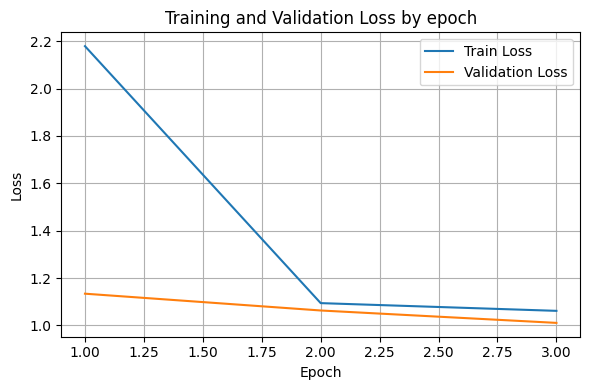

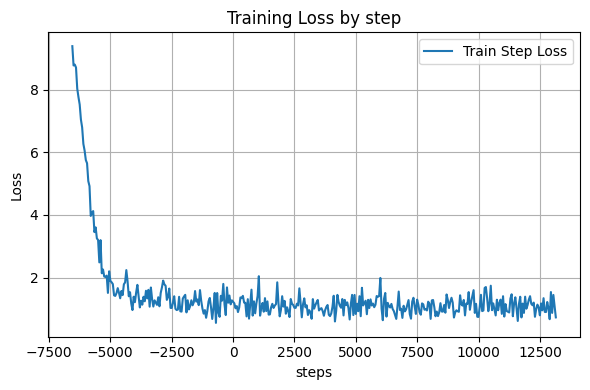

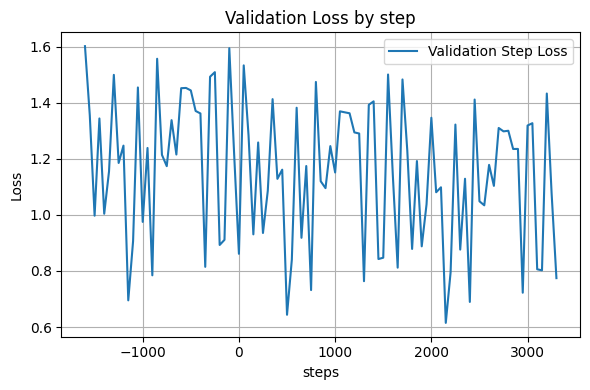

In [28]:
epochs = list(range(1, len(epoch_train_losses) + 1))
plt.figure(figsize=(6, 4))
plt.plot(epochs, epoch_train_losses, label="Train Loss")
plt.plot(epochs, epoch_val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss by epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

train_steps_flat = [s for epoch_nums in all_train_step_nums for s in epoch_nums]
train_losses_flat = [l for epoch_losses in all_train_step_losses for l in epoch_losses]
plt.figure(figsize=(6, 4))
plt.plot(train_steps_flat, train_losses_flat, label="Train Step Loss")
plt.xlabel("steps")
plt.ylabel("Loss")
plt.title("Training Loss by step")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

val_steps_flat = [s for epoch_nums in all_val_step_nums for s in epoch_nums]
val_losses_flat = [l for epoch_losses in all_val_step_losses for l in epoch_losses]
plt.figure(figsize=(6, 4))
plt.plot(val_steps_flat, val_losses_flat, label="Validation Step Loss")
plt.xlabel("steps")
plt.ylabel("Loss")
plt.title("Validation Loss by step")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Inference (15 Points)

Complete the function below to generate comments (positive or negative) 

In [168]:
def generate_comment(model: nn.Module, tokenizer: Any, sentiment: int, max_length: int = 50) -> str:
  
    prefix = "<POS>" if sentiment == 1 else "<NEG>"
    input_ids = tokenizer(prefix, return_tensors="pt").input_ids.to(device)

    generated_tensor = model.generate(input_ids=input_ids, max_length=max_length, temperature=3, top_k=15, top_p=0.8)

    decoded = tokenizer.decode(generated_tensor[0], skip_special_tokens=True)


    if decoded.startswith(prefix):
        comment = decoded[len(prefix):].lstrip()
    else:
        comment = decoded

    return comment


Generate 10 positive and 10 negative comments and evaluate your results

In [169]:

model.eval()

for _ in range(10):
   
    pos = generate_comment(model, tokenizer, sentiment=1, max_length=60)
    
    print(f"Positive Comment: \n {pos}")
    neg = generate_comment(model, tokenizer, sentiment=0, max_length=60)
    print(f"Negative Comment: \n {neg}")

Positive Comment: 
  غذا و غذا خوش و خیلی کیفیت کیفیت خیلی عالی عالی بود که از پ و عالی به خوشمزه بود عالی عالی بود فقط خیلی بد بودن و به دستزه و مزه و کیفیت هم
Negative Comment: 
  پزا به خوشید خیلی سرد رسید خوب بود فقط با به قیمت غذا و خوشمزه به خیلی خوب نبود ولی با عالی رسید بود و خوب نبود که از به غذا سرد بود با هم بد هم به خوش به و خوشم ولی در و
Positive Comment: 
  خیلی خوشزه و غذا خیلی خیلی خیلی خوب خوش و با به عالی بود ولی با کیفیت به بهزه نبود بود ولی کیفیت پیتینی به و خوشم بود بود خوشمزه هم خوب بود خوب نبودزه بود از خیلی
Negative Comment: 
  کیفیت غذا و پیت بود از خوشمزه بود و با عالی به کیفیت به خوشم رسید خیلی عالی بودن و با غذا م و پزا بود بود خیلی خوشم و و خیلی ممنون ازیر نبود هم
Positive Comment: 
  کیفیت کیفیت عالی و خوب و پیتزا عالی بود به عالیزا و عالی و و خوب عالی عالی بود به دست و به دستم و خیلی هم خوشم به به خوشننپون خیلی خوشم بود که و خوب م رسید
Negative Comment: 
  با به به به دستون از غذا کیفیت پزا خوب بود ولی و به کیفیت خوشمزه مزه رسید و به پ پیتزا و کیفیت خیلی 

In my previously trained model the text was not saved. I have trained it once again but the outputs are not as good here is the previous copied version. 

Positive Comment: 
  کیفیت بود و غذا عالی عالی بود و خوب بود من کیفیت خوب بود و با خیلی خوشمزه هم به سفت بود اما غذاها هم کیفیت هم هم ممنون به ممنون
  
Negative Comment: 
  در خیلی خوب بود بود فقط پیتزا غذا به موقع متمزه و خیلی پویل و پخته بود خیلی به دستمون که کیفیت به واقعا خیلی کمیتیت و با سلام پیت به من که هم ممنون
  
Positive Comment: 
  غذا خوش رسید به کیفیت و خیلی بد و کیفیت پویل غذا خوشمزه که در کل بسیار مزه به دستم بود هم کیفیت غذا خیلی خوب نبود
  
Negative Comment: 
  من به متاد و ممنون خیلی عالی و خوشمزه به پ پیتزا بسیار بد و بسیار سرد ممنون و خوب بود با من سس
  
Positive Comment: 
  بسیار ممنون و خوش رسید بود به من پ شده بود ممزه و ممنون ولی پیتزا خوشزا هم سرد خوب بود خیلی کمیتزا خیلی ممنون خیلی خوب بود غذا
  
Negative Comment: 
  این کیفیت واقعا با به من خیلی عالی نبودم به قیمت و عالی بود و خوب خیلی بسیار بد بود با غذا خوب بود ولی کیفیت بسیار بدش و غذا غذا
  
Positive Comment: 
  از از  دپخته بود با با از اینچ من غذا خیلی کم بودن فقط با اینکه  یت بود خیلی ممنون از این این رستم از از از رستوران از کیفیت عالی بود و خوب بود
  
Negative Comment: 
  پخته به ساسفانه غذا بسیار خوش بسیار عالی خیلی خیلی بسیار بسیار عالی بودن و خیلی خوب بود و بسیار بد نبود فقط به دستید از از من و سس بود مزه ولی خوشمزه
  
Positive Comment: 
  خوب نبودم بود و خوب بود فقط این این پیت و خیلی هم هم خیلی خیلی سرد و به به با غذا خوشم رسید مزه نبود از از از کیفیت خیلی به این سس خیلی هم خوشمزه بود ولی از غذا 
  سرد و خیلی عالی بود که
  
Negative Comment: 
  در خیلی عالی بود و عالی بودن با سانه خیلی پولیشده بود و با کیفیت به با کیفیت خوب نبود اما متم پپریتشده به قیمت به سس پ خیلی کم شده بود خیلی به
  
Positive Comment: 
  از خیلی خوشمزه به قیمت عالی و با خوشزاها پیتون بود از من در کل م با غذاها بسیار تازه بود و غذا خیلی تازه نبود و خوش رسید غذا خوب نبود از یکمزه رسید
  
Negative Comment: 
  مت با اینکه در من با تا  ت و با از  ن به قیمت از کیفیت پپر خوب بود با این کیفیت بود با غذا بسیار خیلی خوب نبود در کل به دستم رسید خیلی کم شده بودن و عالی بود در من
  
Positive Comment: 
  خیلی کم به از س با خوشاسفانه از بهاسفانه ممنون از اسن خیلی به جای سس پیتزا عالی نبود خیلی خیلی
  
Negative Comment: 
  به موقع و ممنون ولی متاسف من پ شده که با اینکه پیتخته به موقع و به قیمتش نبود که کیفیت با غذا خیلی خوب بود به دستم با اینخ بود و غذا بد بود و با کیفیت بسیار هم کیفیت خیلی مزه بود و بد ممنون از سفارش با پیتزا خوشزه بود مزه بود که از غذا هم به این رستوران کیفیتش و کیفیت بسیار عالی شده رسید از پیت و بد
  
Positive Comment: 
  خیلی عالی و و تازه به خیلی عالی رسید ممنون رسید و عالی ولی کیفیت هم هم مزه نبود و بسیار تازه و با اینکه خیلی تازه نبود و ممزه بود با از
  
Negative Comment: 
  غذا بسیار غذا که من خیلی خوب بود و مزه که این من پیتون بود که کیفیت بسیار هم خیلی بد کیفیتش هم پیتشش هم سرد به جای غذاها هم به دستم رسید بود خیلی سرد بود در این نون غذا پخته بود و خوب
  
Positive Comment: 
  کیفیت خوب بود با همه از کیفیت عالی بود که از با غذا خوشمزه پیتزا و به من و خوشزا بسیار ممنون پزا خوشیم ولی غذا غذاها بود که خیلی خوب بودن ممنون
  
Negative Comment: 
  این سفارش داد کیفیت با اینکه با کیفیتش من سس خیلی خوش غذا خیلی عالی رسید و کیفیت و سس غذا هم سرد بود هم به به موقع که سفارش داده بودم و به جایش و با سلام پیت و به این این غذا بسیار هم بد داشت به
  
Positive Comment: 
  من خیلی بدم از سس با خیلی خوش خوشمزه خوب به شدت بد و پیتش خیلی سریع و خوشمزه و عالی من غذا عالی و عالی
  
Negative Comment: 
  به قیمت غذا بدید که پیتیتون خیلی پ بود خیلی کم نبود و به کیفیت بسیار مزه و ساند

## Inference Time Hyperparameters (10 Points)

Play with these parameters for the best results:
  
temperature, top_k, top_p

Briefly report what you saw and try to explain why is it happening. What is the effect of each one?

**Your Report**: 

temperature: 
low T sharpens the distribution, making the highest-logit tokens even more dominant.
low numbers made the model so deterministic and the sentences ended too seen to observe anythin at all. i had to use numbers around 5. it is larger than i expected and sometimes made the model create nonsense. 
the model is not well-trained and is unsure if the next token. it is only through high stochasticity that is can continue to generate text


top-p:
it is an adaptive approach: it naturally tightens when confident and loosens when not. That flexibility usually yields the best balance between coherence and creativity without you having to tune a fixed k.
Dynamically adjusts the number of candidates. it is Better for diverse and creative outputs. i set it around 0.8

top-k: At each step, you keep only the k tokens with highest probability, zeroing out the rest.
fixed number of candidates. better for more deterministic outputs.
Top-k enforces a fixed-size candidate set. If you know you want exactly k choices, this gives consistent diversity, but it can be too restrictive when the distribution is very peaky or too permissive when it’s very flat

smaller values that 10 made it generate the same outputs. it limited the creativity. and too large values made it meaningless. a value around 20 seemed to work for me.



